In [1]:
import argparse
import hashlib
import logging
import math
import os
import warnings
from pathlib import Path
from typing import Optional
import cv2

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import datasets
import diffusers
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    UNet2DConditionModel,
    StableDiffusionControlNetPipeline,
    StableDiffusionImg2ImgPipeline,
    ControlNetModel,
    UniPCMultistepScheduler
)
from diffusers.loaders import AttnProcsLayers
from diffusers.models.cross_attention import LoRACrossAttnProcessor
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available, load_image
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

ModuleNotFoundError: No module named 'cv2'

In [2]:
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

In [3]:
accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision=None,
        log_with=None,
        logging_dir=None,
    )

In [4]:
image = Image.open("/home/fungi0313/LoRA-DreamBooth-Training-UI/data/black_LUAD/TCGA-55-A57B-01Z-00-DX1.8D3C7063-3AF6-4839-A656-F844EC0AF9DB_26_14.jpg")
image = resize_for_condition_image(image, 512)
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

### ControlNet v1.5

In [ ]:
# lllyasviel/sd-controlnet-canny 只能搭配 v1.5的sd


# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float32)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float32
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
# pipe.enable_xformers_memory_efficient_attention()

# pipe.enable_model_cpu_offload()

# generate image
generator = torch.manual_seed(0)
image = pipe(
    "futuristic-looking woman", num_inference_steps=20, generator=generator, image=canny_image
).images[0]

### ControlNet v2

In [5]:
# thibaud/controlnet-sd21-canny-diffusers 可以配合v2.1

controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-sd21-canny-diffusers", torch_dtype=torch.float32)
pipeline = StableDiffusionControlNetPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", controlnet=controlnet, torch_dtype=torch.float32)
pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to(accelerator.device)

# # load attention processors
pipeline.unet.load_attn_procs("kaneyxx/black_LUAD_2x_3500_1e-4")

### 單純的SD v2.1

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-2-1-base", revision=None, torch_dtype=torch.float32,
        )
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to(accelerator.device)

# load attention processors
pipeline.unet.load_attn_procs("kaneyxx/black_LUAD_2x_3500_1e-4")

### SD v2.1 Img2Img + text_prompt

In [19]:
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
            "stabilityai/stable-diffusion-2-1-base", revision=None, torch_dtype=torch.float32
        )
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to(accelerator.device)

# load attention processors
pipeline.unet.load_attn_procs("kaneyxx/black_LUAD_2x_3500_1e-4")

### 關閉NSFW

In [20]:
pipeline.safety_checker = lambda images, clip_input: (images, False)

### 生成

In [21]:
generator = torch.Generator(device="cuda").manual_seed(0)
prompt = 1 * ["a photo of BlackLUAD"]
images = pipeline(
    "a photo of BlackLUAD", 
    num_inference_steps=25, 
    generator=generator, 
    image=image
).images

100%|██████████| 20/20 [00:02<00:00,  6.74it/s]


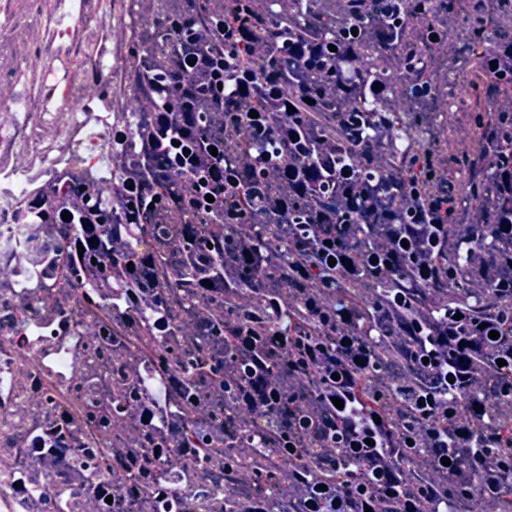

In [22]:
images[0]

In [ ]:
images[0].save("./control_test.png")

<Figure size 1500x800 with 0 Axes>

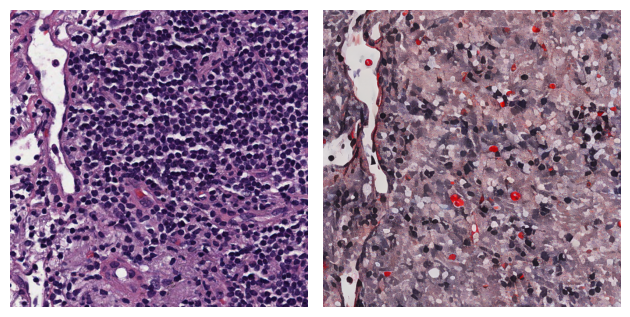

In [16]:
# import matplotlib.pyplot as plt 

# original_image = Image.open("/home/fungi0313/LoRA-DreamBooth-Training-UI/data/black_LUAD/TCGA-55-A57B-01Z-00-DX1.8D3C7063-3AF6-4839-A656-F844EC0AF9DB_26_14.jpg")
# image = resize_for_condition_image(original_image, 512)

# # fig.set_figheight(image.size[1])  # figure height 和 圖片高度一致
# # fig.set_figwidth(image.size[0])   # figure width 和 圖片寬度一致
# fig = plt.figure(figsize=(15, 8)) 
# fig, axs = plt.subplots(1, 2)

# axs[0].imshow(image)
# axs[0].axis("off")
# axs[1].imshow(images[0])
# axs[1].axis("off")

# fig.tight_layout()  
# plt.savefig('result2.png', )  

In [ ]:
generated_image_dir = Path(args.output_dir) / 'generated_images'
generated_image_dir.mkdir()
for i, image in enumerate(images):
    out_path = generated_image_dir / f'image_{i}.png'
    image.save(out_path)

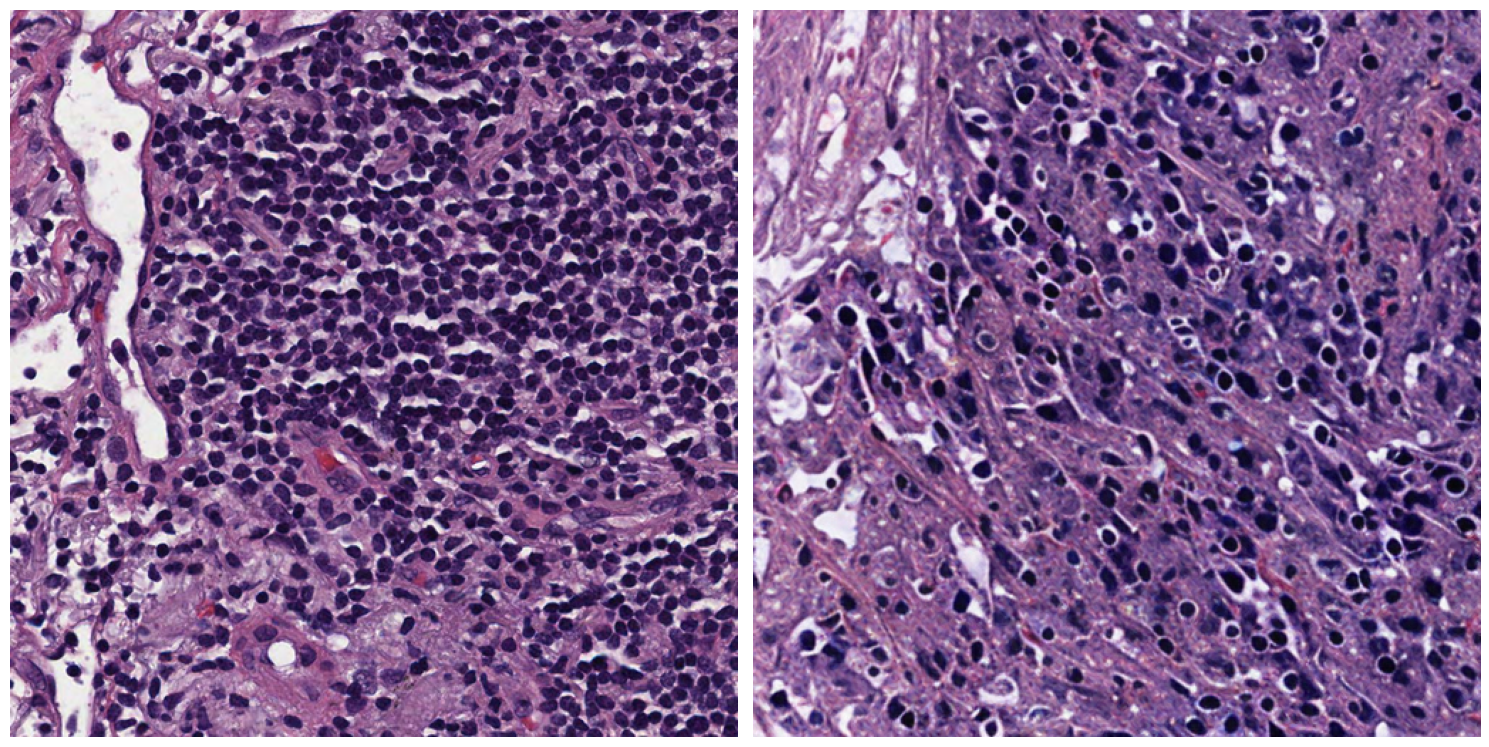

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

original_image = Image.open("/home/fungi0313/LoRA-DreamBooth-Training-UI/data/black_LUAD/TCGA-55-A57B-01Z-00-DX1.8D3C7063-3AF6-4839-A656-F844EC0AF9DB_26_14.jpg")    
image = resize_for_condition_image(original_image, 512)  

fig = plt.figure(figsize=(15, 8))

grid = gridspec.GridSpec(1, 2)  # 1 row, 2 columns
ax1 = plt.subplot(grid[0, 0])  # left subplot
ax2 = plt.subplot(grid[0, 1])  # right subplot

ax1.imshow(image)  
ax1.axis("off")
ax2.imshow(images[0])
ax2.axis("off")    

fig.tight_layout()
plt.savefig('result2.png')